In [1]:
import pandas as pd 
import numpy as np
import sys 
sys.path.append('../../')
from vnf_placement.SubstrateNetwork.SN import *
from vnf_placement.VNFR.VNFR import * 
from vnf_placement.PlacementModule.Mlflow import * 
from vnf_placement.PlacementModule.PlacementEnv import *
from vnf_placement.PlacementModule.PlacementModule import *
#from kind_automatisation.scripts.ModulePlacement.BD_management import *
import os 
import pickle
import random
import requests
import mlflow
from stable_baselines3.common.logger import HumanOutputFormat, KVWriter, Logger

In [36]:
os.environ["no_proxy"] = 'localhost,127.0.0.1'

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
with open('../../topologie_generation/GT-ITM/ts100.pkl', 'rb') as f:
    graph = pickle.load(f)

In [4]:
# Get Loaded resources 
loaded = requests.get('http://localhost:8000/pth/clusters_all_loaded')

loaded_cls = loaded.json()['loaded_clusters']
# Get limits infra 
infra = requests.get('http://localhost:8000/db/infra_limits')
limits_cls = infra.json()['infra_db']

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [3]:
nsparse_adj_list = graph["ADJ_LIST"]
print(nsparse_adj_list)

NameError: name 'graph' is not defined

In [3]:
#nsparse_adj_list = graph["ADJ_LIST"]
#print(nsparse_adj_list)
def matrix_to_sparse_adjacency(matrix):
    sparse_adjacency = []
    
    for i in range(len(matrix)):
        for j in range(i + 1, len(matrix[i])):
            if matrix[i][j] != 0:
                sparse_adjacency.append([i,j])
    
    return sparse_adjacency

In [4]:
#adj_mat = graph["ADJ_MAT"]
#nodes_type = graph["NODES_TYPES"]
#nsparse_adj_list = graph["ADJ_LIST"]
#edges_clusters = graph["EDGES_CLUSTERS"]
def get_available_resources(limits, loaded):
    available = {}
    for cls in limits:
        cluster_id = cls["ID"]
        if cluster_id in loaded :
            available[cluster_id] = {}
            available[cluster_id]["RAM"] = cls["ram"] - loaded[cluster_id]["RAM"]
            available[cluster_id]["CPU"] = cls["cpu"] - loaded[cluster_id]["CPU"]
    return available

dispo = get_available_resources(limits_cls, loaded_cls)

NameError: name 'limits_cls' is not defined

In [13]:
""" 
dispo = {
 'cluster-c1': {'RAM': 2861.81640625, 'CPU': 2.2299888390269187},
 'cluster-c2': {'RAM': 2920.70703125, 'CPU': 2.378481268636885},
 'cluster-c3': {'RAM': 4916.9765625, 'CPU': 2.7394677932832834},
 'cluster-c4': {'RAM': 4339.5703125, 'CPU': 2.7404578535238193},
 'cluster-c5': {'RAM': 4327.640625, 'CPU': 2.7412230010117176},
 'cluster-c6': {'RAM': 4335.30859375, 'CPU': 2.7307449007273683},
 'cluster-c7': {'RAM': 4356.19921875, 'CPU': 2.7263802633370795},
 'cluster-c8': {'RAM': 4370.375, 'CPU': 2.7438676358997673},
 'cluster-c9': {'RAM': 4347.39453125, 'CPU': 2.740566194880344},
 'cluster-c10': {'RAM': 4347.39453125, 'CPU': 2.740566194880344},
 'cluster-c11': {'RAM': 4347.39453125, 'CPU': 2.740566194880344}
 }
"""
dispo = {'cluster-c1': {'RAM': 4372.95703125, 'CPU': 2.7409564815426513}, 
         'cluster-c10': {'RAM': 4489.69140625, 'CPU': 2.7610473437294}, 
        'cluster-c2': {'RAM': 4493.51171875, 'CPU': 2.7736120196913383},
        'cluster-c3': {'RAM': 4495.4609375, 'CPU': 2.7832016581886196},
        'cluster-c4': {'RAM': 4461.375, 'CPU': 2.757656933342214}, 
        'cluster-c5': {'RAM': 4501.0390625, 'CPU': 2.767851993789014}, 
        'cluster-c6': {'RAM': 4494.31640625, 'CPU': 2.7732968842827685},
        'cluster-c7': {'RAM': 4498.8125, 'CPU': 2.7635888338288512},
        'cluster-c8': {'RAM': 4468.6484375, 'CPU': 2.7840575406645467},
        'cluster-c9': {'RAM': 4448.27734375, 'CPU': 2.764806127839378}, 
         'cluster-c11': {'RAM': 4512.73828125, 'CPU': 2.7766413269517054}}

In [14]:
num_nodes = len(dispo.keys())
print(num_nodes)

11


In [6]:
adj_list = [
    [1,2],
    [3],
    [3,4,6],
    [6,7],
    [5],
    [6],
    [7],
    [8,10]
    ,[9]
    ,[10],
      [] ]
print(adj_list)
num_nodes = len(adj_list)
adj_matrix = np.zeros((num_nodes, num_nodes), dtype=int)

for node, neighbors in enumerate(adj_list):
    for neighbor in neighbors:
        adj_matrix[node, neighbor] = 1
        adj_matrix[neighbor,node ] = 1


[[1, 2], [3], [3, 4, 6], [6, 7], [5], [6], [7], [8, 10], [9], [10], []]


In [7]:
def matrix_to_sparse_adjacency(matrix):
    sparse_adjacency = []
    
    for i in range(len(matrix)):
        for j in range(i + 1, len(matrix[i])):
            if matrix[i][j] != 0:
                sparse_adjacency.append([i,j])
    
    return sparse_adjacency

nsparse_adj_list = matrix_to_sparse_adjacency(adj_matrix)

In [8]:
print(nsparse_adj_list)
print(len(nsparse_adj_list))

[[0, 1], [0, 2], [1, 3], [2, 3], [2, 4], [2, 6], [3, 6], [3, 7], [4, 5], [5, 6], [6, 7], [7, 8], [7, 10], [8, 9], [9, 10]]
15


In [9]:
#Parameteres to store in a config File :

DEFAULT_PN = {
    "Edge" : {
        "CPU" : [7],
        "RAM" : [8192],
    },
    "Transport" : {
        "CPU" : [7],
        "RAM" : [8192],
    },
    "Core" : {
        "CPU" : [7],
        "RAM" : [8192],
    }
}

DEFAULT_PL = {
    "Edge" : {
        "BW" : [50],
        "Delay" : [3],
    },
    "Transport" : {
        "BW" : [50],
        "Delay" : [2.5],
    },
    "Core" : {
        "BW" :  [50],
        "Delay" : [2],
    }
}

DEFAULT_VNF = {
    "CPU" : [0.05, 1],
    "RAM" : [64, 1024],
}

DEFAULT_VL = {
    "BW" : [2,3,4],
    "Delay" : [2,5]
}



In [10]:
#Define boundaries of each variable of our state 
adj_mat = adj_matrix
#Boundaries of VNFs, VLs
RL_boundaries = {}

RL_boundaries["MAX_DEFAULT_VNFS_CPU"] = max(DEFAULT_VNF["CPU"])
RL_boundaries["MIN_DEFAULT_VNFS_CPU"] = min(DEFAULT_VNF["CPU"])
RL_boundaries["MAX_DEFAULT_VNFS_RAM"] = max( DEFAULT_VNF["RAM"] )
RL_boundaries["MIN_DEFAULT_VNFS_RAM"] = min( DEFAULT_VNF["RAM"])

RL_boundaries["MAX_SERVICES_BW"] = max(DEFAULT_VL["BW"]) * 2 
RL_boundaries["MAX_SERVICES_DELAY"] = max(DEFAULT_VL["Delay"])

RL_boundaries["MIN_SERVICES_BW"] = min(DEFAULT_VL["BW"]) 
RL_boundaries["MIN_SERVICES_DELAY"] = min(DEFAULT_VL["Delay"])

#Number of VNFs in a VNFR
RL_boundaries["MIN_SERVICES_VNFS"], RL_boundaries["MAX_SERVICES_VNFS"] = [8 , 8]



#Boundaries of PNs, PLs
#PLs
RL_boundaries["MAX_DEFAULT_BW"] = max(max(DEFAULT_PL[d]["BW"]) for d in DEFAULT_PL)
RL_boundaries["MIN_DEFAULT_BW"] = 0


RL_boundaries["MAX_DEFAULT_DELAY"] = max(max(DEFAULT_PL[d]["Delay"]) for d in DEFAULT_PL)
RL_boundaries["MIN_DEFAULT_DELAY"] = min(min(DEFAULT_PL[d]["Delay"]) for d in DEFAULT_PL)

#PNs
RL_boundaries["MAX_DEG"] = max(int(adj_mat[i,:].sum()) for i in range(adj_mat.shape[0]))
RL_boundaries["MIN_DEG"] = min(int(adj_mat[i,:].sum()) for i in range(adj_mat.shape[0]))

RL_boundaries["MAX_DEFAULT_NODE_BW"] = RL_boundaries["MAX_DEFAULT_BW"] * RL_boundaries["MAX_DEG"]
RL_boundaries["MIN_DEFAULT_NODE_BW"] = 0

RL_boundaries["MAX_DEFAULT_NODE_DELAY"] = 20.0
RL_boundaries["MIN_DEFAULT_NODE_DELAY"] = 0

RL_boundaries["MAX_DEFAULT_CPU"] = max(max(DEFAULT_PN[d]["CPU"]) for d in DEFAULT_PN) 
RL_boundaries["MAX_DEFAULT_RAM"] = max(max(DEFAULT_PN[d]["RAM"]) for d in DEFAULT_PN)   

RL_boundaries["MIN_DEFAULT_CPU"] = 0 
RL_boundaries["MIN_DEFAULT_RAM"] = 0  
 



  

RL_boundaries["MIN_DEFAULT_NODE_BW"] = 0

In [11]:
RL_boundaries

{'MAX_DEFAULT_VNFS_CPU': 1,
 'MIN_DEFAULT_VNFS_CPU': 0.05,
 'MAX_DEFAULT_VNFS_RAM': 1024,
 'MIN_DEFAULT_VNFS_RAM': 64,
 'MAX_SERVICES_BW': 8,
 'MAX_SERVICES_DELAY': 5,
 'MIN_SERVICES_BW': 2,
 'MIN_SERVICES_DELAY': 2,
 'MIN_SERVICES_VNFS': 8,
 'MAX_SERVICES_VNFS': 8,
 'MAX_DEFAULT_BW': 50,
 'MIN_DEFAULT_BW': 0,
 'MAX_DEFAULT_DELAY': 3,
 'MIN_DEFAULT_DELAY': 2,
 'MAX_DEG': 4,
 'MIN_DEG': 2,
 'MAX_DEFAULT_NODE_BW': 200,
 'MIN_DEFAULT_NODE_BW': 0,
 'MAX_DEFAULT_NODE_DELAY': 20.0,
 'MIN_DEFAULT_NODE_DELAY': 0,
 'MAX_DEFAULT_CPU': 7,
 'MAX_DEFAULT_RAM': 8192,
 'MIN_DEFAULT_CPU': 0,
 'MIN_DEFAULT_RAM': 0}

In [14]:
print(loaded_cls)
print(limits_cls)
print(nsparse_adj_list)

NameError: name 'loaded_cls' is not defined

In [27]:
"""
nsparse_adj_list = []
for i in range(num_nodes):
    for k in range(i + 1, num_nodes):
        #print(f"{i}:{k}")
        nsparse_adj_list.append([i, k])
"""


'\nnsparse_adj_list = []\nfor i in range(num_nodes):\n    for k in range(i + 1, num_nodes):\n        #print(f"{i}:{k}")\n        nsparse_adj_list.append([i, k])\n'

In [15]:
_domain_id = 0
nb_nodes = adj_mat.shape[0]
_PNS = {}
nodes_type = [1, 0, 0, 2, 1, 0, 2, 2, 0, 1, 0]#[1 for i in range(nb_nodes)]
edges_clusters = []

edges_clusters = {  0 : [0, 4, 9] 
                    #[i for i in range(nb_nodes)]
                 }
clusters = list(dispo.keys()) 
print(edges_clusters)
for i in range(nb_nodes): 
    if nodes_type[i] == 0 :
        _type = "Transport"
    elif nodes_type[i] == 1 :
        _type = "Edge"
    elif nodes_type[i] == 2 :
        _type = "Core"

    _cpu = dispo[clusters[i]]["CPU"]#random.choice(DEFAULT_PN[_type]["CPU"])
    _ram = dispo[clusters[i]]["RAM"]#random.choice(DEFAULT_PN[_type]["RAM"])
    if _type == "Edge" :
        for j in edges_clusters :
            if i in edges_clusters[j] : 
                _egc = j 
                break
        _egc = i
        print(_ram)
        print(_cpu)
        _pn = PN(i, _cpu,  _ram, _domain_id, type = _type, edge_cluster = _egc)
    else : 
        _pn = PN(i, _cpu,  _ram, _domain_id, type = _type)
    _PNS[i] = _pn

{0: [0, 4, 9]}
4372.95703125
2.7409564815426513
4461.375
2.757656933342214
4448.27734375
2.764806127839378


In [16]:
_PLS = {}
for j in range(len(nsparse_adj_list)):
    src , dist = nsparse_adj_list[j]
    _type = None 
    if (nodes_type[src] == 0 and nodes_type[dist] == 1) or (nodes_type[src] == 1 and nodes_type[dist] == 0):
        _type = "Edge"
    elif (nodes_type[src] == 0 and nodes_type[dist] == 0) or (nodes_type[src] == 0 and nodes_type[dist] == 2) or (nodes_type[src] == 2 and nodes_type[dist] == 0): 
        _type = "Transport"
    elif (nodes_type[src] == 2 and nodes_type[dist] == 2) : 
        _type = "Core"


    _p1 = _PNS[src]
    _p2 = _PNS[dist]

    _bw = 100#random.choice(DEFAULT_PL[_type]["BW"])
    _delay = random.choice(DEFAULT_PL[_type]["Delay"])
    _pl = PL(_p1, _p2 ,_bw,_delay)
    _PLS[j] = _pl


In [17]:
print(_PLS)

{0: ID:0/1 Attrs: [100   3], 1: ID:0/2 Attrs: [100   3], 2: ID:1/3 Attrs: [100.    2.5], 3: ID:2/3 Attrs: [100.    2.5], 4: ID:2/4 Attrs: [100   3], 5: ID:2/6 Attrs: [100.    2.5], 6: ID:3/6 Attrs: [100   2], 7: ID:3/7 Attrs: [100   2], 8: ID:4/5 Attrs: [100   3], 9: ID:5/6 Attrs: [100.    2.5], 10: ID:6/7 Attrs: [100   2], 11: ID:7/8 Attrs: [100.    2.5], 12: ID:7/10 Attrs: [100.    2.5], 13: ID:8/9 Attrs: [100   3], 14: ID:9/10 Attrs: [100   3]}


In [18]:
_domain = Domain(0, "D", adj_mat, nsparse_adj_list, _PNS, _PLS)

In [20]:
_domain = Domain(0, "D", adj_mat, nsparse_adj_list, None, None, _adj_attrs = None, _pns_attrs = None)

AttributeError: 'NoneType' object has no attribute 'shape'

In [19]:
_domain.build_adj_attirbutes().shape
adj = _domain.build_adj_attirbutes()
attrs = _domain.get_attributes_pns()
_domaines = {
    _domain._id :  _domain
}

In [20]:
from stable_baselines3.common.monitor import Monitor
from sb3_contrib import MaskablePPO
from stable_baselines3 import PPO, DQN
from torch_geometric.nn import ChebConv, ARMAConv
import datetime
from vnf_placement.PlacementModule.Models import * 

/home/ryad/rl-multi-domain-for-multi-placement/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [60]:
_chain = PM.create_random_request(_type="5g")._chain_service

In [63]:
print(_chain.get_VNFs_BW_delay().shape)

(12, 2)


In [21]:
PM = PlacementModule(_domaines, RL_boundaries, DEFAULT_VNF, DEFAULT_VL, edges_clusters, _init_load = 10)

params = {
        "ep" : "Request-successful",
        "lp" : 0.2,               #load pourcentage for the load reset  
        "rew_st_s" : 20,     
        "rew_st_f" : 0,     
        "rew_chain_s" : 0,
        "rew_chain_f" : - 50,
        "rew_type" : "Best",
        "rew_rs_step_tries" : 5,  
        }

log_dir = "./speslogs"

load_pourcent = params["lp"]
_episode_type = params["ep"]
_penv = PlacementEnv(_id_domain = 0,boundaries= RL_boundaries, requests= None,
                        PModule = PM, episode_type = _episode_type, reward_type = params["rew_type"], 
                        _reset_load_pourcent = load_pourcent, 
                        mask_cpu = False,
                        mask_ram = False, 
                        mask_bw = False, 
                        mask_delay = True,
                        rew_st_s = params["rew_st_s"] , 
                        rew_st_f = params["rew_st_f"],
                        rew_chain_s = params["rew_chain_s"],
                        rew_chain_f = params["rew_chain_f"],
                        rew_rs_step_tries = params["rew_rs_step_tries"],
                        
                     )

In [158]:
model_ray = PPO(
                "MultiInputPolicy", 
                _penv, 
                verbose=1, 
                tensorboard_log = log_dir, 
                device= "cuda", 
                #**ppo_parm,
)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [159]:
model_ray.learn(400000)

Shutter island
Logging to ./speslogs/PPO_5
because hadi
Shutter island
CPU: 0.07975265755385963 RAM: 0.1560121244923901 BW: 0.0
ACP:1, REF:0, AR:1.0
because hadi
Shutter island
CPU: 0.1007464232737465 RAM: 0.1897937104470382 BW: 0.0
ACP:1, REF:0, AR:1.0
because hadi
Shutter island
CPU: 0.10283881871993772 RAM: 0.18979160794481298 BW: 0.0
ACP:1, REF:0, AR:1.0
Shutter island
CPU: 0.12957936303246753 RAM: 0.235008969232957 BW: 0.0
ACP:3, REF:0, AR:1.0
because hadi
Shutter island
CPU: 0.07447751961544125 RAM: 0.14479458278972845 BW: 0.0
ACP:0, REF:0, AR:0
Shutter island
CPU: 0.12764179601432868 RAM: 0.23500485695997908 BW: 0.0
ACP:3, REF:0, AR:1.0
because hadi
Shutter island
CPU: 0.07949368436428073 RAM: 0.1447968864216348 BW: 0.0
ACP:0, REF:0, AR:0
because hadi
Shutter island
CPU: 0.07583074555985037 RAM: 0.14479361778760091 BW: 0.0
ACP:0, REF:0, AR:0
because hadi
Shutter island
CPU: 0.07724456563684501 RAM: 0.1447922486888492 BW: 0.0
ACP:0, REF:0, AR:0
because hadi
Shutter island
CPU: 0.

KeyboardInterrupt: 

In [216]:
sr

NameError: name 'sr' is not defined

In [237]:
done = False 

action = 0
t = 0
obs = _penv.reset()
if "Adj-List" in obs:
    del obs["Adj-List"]
for i in range(1):
    action = 0
    while not done :
        act = 0 #int(model_test.predict(obs, deterministic=False)[0])
        #print(act)
        print(obs["Vnf"])
        #print(obs["Infra"])
        obs, reward, done, _ = _penv.step(act)
        if reward > 0:
            print("Pass")
        else:
            print("No Pass")
        if "Adj-List" in obs:
            del obs["Adj-List"]
        print(obs["Infra"].shape)
        if reward < 0 :
            action = action + 1
            if action > 9 :
                done = True 
        else :
            t = t + 1 
        print("///////////////////////////")
    obs = _penv.reset()
        
    if "Adj-List" in obs:
        del obs["Adj-List"]
    print(f"Le nombre de VNF placées: {t}")
    t = 0
    done = False 

[6.00e-02 3.00e+02 4.55e+00]
Pass
(11, 3)
///////////////////////////
[5.000e-02 1.280e+02 2.928e+00]
No Pass
(11, 3)
///////////////////////////
[5.000e-02 1.280e+02 2.928e+00]
No Pass
(11, 3)
///////////////////////////
[5.000e-02 1.280e+02 2.928e+00]
No Pass
(11, 3)
///////////////////////////
[5.000e-02 1.280e+02 2.928e+00]
No Pass
(11, 3)
///////////////////////////
[5.000e-02 1.280e+02 2.928e+00]
No Pass
(11, 3)
///////////////////////////
[5.000e-02 1.280e+02 2.928e+00]
No Pass
(11, 3)
///////////////////////////
[5.000e-02 1.280e+02 2.928e+00]
No Pass
(11, 3)
///////////////////////////
[5.000e-02 1.280e+02 2.928e+00]
No Pass
(11, 3)
///////////////////////////
[5.000e-02 1.280e+02 2.928e+00]
No Pass
(11, 3)
///////////////////////////
[5.000e-02 1.280e+02 2.928e+00]
No Pass
(11, 3)
///////////////////////////
Le nombre de VNF placées: 1


In [161]:
d, path, _ = _domain.dijkstra(4, mask_bw= True, required_BW = 0, required_delay= 1.5, mask_delay= False, MAX_DEFAULT_NODE_DELAY =2500.0) #Costs: [ 6  7  3  5  0  3  5  7  9 12  9]

#D

Costs: [ 6.   8.   3.   5.5  0.   3.   5.5  7.5 10.  13.  10. ]


In [125]:
print(d)
print(path)

[ 0.   3.   3.   5.5  6.   8.   5.5  7.5 10.  13.  10. ]
{0: [], 1: [1], 2: [2], 3: [1, 3], 4: [2, 4], 5: [2, 6, 5], 6: [2, 6], 7: [1, 3, 7], 8: [1, 3, 7, 8], 9: [1, 3, 7, 8, 9], 10: [1, 3, 7, 10]}


In [75]:
done = False 

action = 0
t = 0
obs = _penv.reset()
for i in range(1000):
    del obs["Adj-List"]
    while not done :
        print(obs)
        action = 1 #model_test.predict(obs)
        obs, reward, done, _ = _penv.step(action)
        del obs["Adj-List"]
        print(obs)
        
        t = t + 1 
    obs = _penv.reset()
    print(f"Le nombre de VNF placées: {t}")
    t = 0
    done = False 

{'Infra': array([[2.22998881e+00, 2.86181641e+03, 2.00000000e+02, 2.50000000e+03],
       [2.37848115e+00, 2.92070703e+03, 2.00000000e+02, 2.50000000e+03],
       [2.73946786e+00, 4.91697656e+03, 4.00000000e+02, 3.00000000e+00],
       [2.74045777e+00, 4.33957031e+03, 4.00000000e+02, 2.50000000e+03],
       [2.74122310e+00, 4.32764062e+03, 2.00000000e+02, 0.00000000e+00],
       [2.73074484e+00, 4.33530859e+03, 2.00000000e+02, 3.00000000e+00],
       [2.72638035e+00, 4.35619922e+03, 4.00000000e+02, 2.50000000e+03],
       [2.74386764e+00, 4.37037500e+03, 4.00000000e+02, 2.50000000e+03],
       [2.74056625e+00, 4.34739453e+03, 2.00000000e+02, 2.50000000e+03],
       [2.74056625e+00, 4.34739453e+03, 2.00000000e+02, 2.50000000e+03],
       [2.74056625e+00, 4.34739453e+03, 2.00000000e+02, 2.50000000e+03]]), 'Vnf': array([6.00e-02, 3.00e+02, 0.00e+00, 4.55e+00], dtype=float32)}
{'Infra': array([[2.22998881e+00, 2.86181641e+03, 2.00000000e+02, 2.50000000e+03],
       [2.31848115e+00, 2.62070

KeyError: 'Adj-List'

In [ ]:
_mask_cpu = False
_mask_ram = False
load_pourcent = 1.0
_episode_type = "Batch_Requests"

slice_requests = test_slice_requests
log_dir = None 
_test_mode = True

_pm = copy.deepcopy(_pm_test)
print(_episode_type)
_test_env = PlacementEnv(_id_domain = 0,boundaries= RL_boundaries, requests= test_slice_requests, PModule = _pm, episode_type = _episode_type, mask_bw = True, mask_delay = True, reward_type = "Best", _reset_load_pourcent = load_pourcent, mask_cpu = _mask_cpu, mask_ram = _mask_ram, _test_mode = _test_mode)
policy_kwargs = dict(
     features_extractor_class=CustomCombinedExtractor,
)


done = False
obs = _test_env.reset()
while not done : 
    masque = np.array(_test_env.action_masks())
    action = model.predict(obs, action_masks=masque, deterministic= False)
    obs, reward, done, info = _test_env.step(int(action[0]))

ch = _test_env.reset()  

Batch_Requests
REQ:(1)VNF: (3/3) Reward: 210 R_del: 0.94 R_CPU: 0.8571428571428571 R_RAM 0.75
REQ:(2)VNF: (6/6) Reward: 210 R_del: 0.9248 R_CPU: 1.0 R_RAM 1.0
REQ:(3)VNF: (6/6) Reward: 210 R_del: 0.94 R_CPU: 0.8571428571428571 R_RAM 0.75
REQ:(4)VNF: (7/7) Reward: 210 R_del: 0.92 R_CPU: 0.8333333333333334 R_RAM 0.8333333333333334
REQ:(5)VNF: (8/8) Reward: 210 R_del: 0.8648 R_CPU: 1.0 R_RAM 1.0
REQ:(6)VNF: (5/8) Reward: -100 R_del: 0.9248 R_CPU: 0.16666666666666666 R_RAM 0.0
REQ:(7)VNF: (3/6) Reward: -100 R_del: 0.8648 R_CPU: 0.16666666666666666 R_RAM 0.0
REQ:(8)VNF: (2/10) Reward: -100 R_del: 1.0 R_CPU: 0.5 R_RAM 0.3333333333333333
REQ:(9)VNF: (2/8) Reward: -100 R_del: 1.0 R_CPU: 0.5 R_RAM 0.0
REQ:(10)VNF: (3/10) Reward: -100 R_del: 0.8648 R_CPU: 0.16666666666666666 R_RAM 0.0
REQ:(11)VNF: (8/10) Reward: -100 R_del: 1.0 R_CPU: 0.3333333333333333 R_RAM 0.3333333333333333
REQ:(12)VNF: (2/3) Reward: -100 R_del: 1.0 R_CPU: 0.4166666666666667 R_RAM 0.4666666666666667
REQ:(13)VNF: (6/9) Reward

In [ ]:
test_slice_requests

{0: <vnf_placement.VNFR.VNFR.Slice_request at 0x7f80d93b37f0>,
 1: <vnf_placement.VNFR.VNFR.Slice_request at 0x7f80d3f8df30>,
 2: <vnf_placement.VNFR.VNFR.Slice_request at 0x7f80d3f8de70>,
 3: <vnf_placement.VNFR.VNFR.Slice_request at 0x7f80d3f8dde0>,
 4: <vnf_placement.VNFR.VNFR.Slice_request at 0x7f80d3f8e740>,
 5: <vnf_placement.VNFR.VNFR.Slice_request at 0x7f80d3f8fc40>,
 6: <vnf_placement.VNFR.VNFR.Slice_request at 0x7f80d3fb8040>,
 7: <vnf_placement.VNFR.VNFR.Slice_request at 0x7f80d3fb8580>,
 8: <vnf_placement.VNFR.VNFR.Slice_request at 0x7f80d3fb8d00>,
 9: <vnf_placement.VNFR.VNFR.Slice_request at 0x7f80d3fb9300>,
 10: <vnf_placement.VNFR.VNFR.Slice_request at 0x7f80d3fb9a80>,
 11: <vnf_placement.VNFR.VNFR.Slice_request at 0x7f80d3fba2c0>,
 12: <vnf_placement.VNFR.VNFR.Slice_request at 0x7f80d3fba740>,
 13: <vnf_placement.VNFR.VNFR.Slice_request at 0x7f80d3fbad40>,
 14: <vnf_placement.VNFR.VNFR.Slice_request at 0x7f80d3fbb4c0>,
 15: <vnf_placement.VNFR.VNFR.Slice_request at 0x7

In [ ]:
test_slice_requests = {}
for i in range(70): 
    _SR = Slice_request(init= "rand",edge = "rand", DEFAULT_VNF= DEFAULT_VNF, DEFAULT_VL = DEFAULT_VL, edge_clusters = edges_clusters, edge_node = "rand", min_nb_vnfs = RL_boundaries["MIN_SERVICES_VNFS"], max_nb_vnfs = RL_boundaries["MAX_SERVICES_VNFS"])
    test_slice_requests[i] = _SR

In [35]:
os.environ["no_proxy"] = 'localhost,127.0.0.1'

In [315]:
from mlflow.tracking import MlflowClient
MLFLOW_TRACKING_URI = "http://127.0.0.1:5005/"
#PM = PlacementModule(_domaines, RL_boundaries, DEFAULT_VNF, DEFAULT_VL, edges_clusters)
mlflow_volume = "/home/ryad/rl-multi-domain-for-multi-placement/vnf_placement/PlacementModule/volume_mlflow/mlflow"
model_name = "salim" 

tuner = FineTuner(
    boundaries= RL_boundaries,
    placemet_module= None,
    domaines = _domaines,
    DEFAULT_VNF = DEFAULT_VNF,
    DEFAULT_VL = DEFAULT_VL,
    edges_clusters = edges_clusters, 
    mlflow_url= MLFLOW_TRACKING_URI,
    model_name= model_name,
    mlflow_volume = mlflow_volume

)

In [316]:
tuner.tune(1)

because hadi                                         
because hadi                                         
because hadi                                         
because hadi                                         
because hadi                                         
because hadi                                         
because hadi                                         
because hadi                                         
because hadi                                         
because hadi                                         
because hadi                                         
because hadi                                         
because hadi                                         
because hadi                                         
because hadi                                         
because hadi                                         
because hadi                                         
because hadi                                         
because hadi                

job exception: list index out of range



  0%|          | 0/1 [08:00<?, ?trial/s, best loss=?]


IndexError: list index out of range

In [55]:
client = MlflowClient(tracking_uri= "http://127.0.0.1:5005")


In [57]:
client.create_experiment("PPO")

'770135401685055216'

In [40]:
client.create_experiment("JoJo")

'250555616467008833'

In [35]:
test_model = tuner.get_prod_model(model_name)

/home/ryad/rl-multi-domain-for-multi-placement/venv/lib/python3.10/site-packages/stable_baselines3/common/policies.py:458: UserWarning: As shared layers in the mlp_extractor are deprecated and will be removed in SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


In [ ]:
stop_train_callback = StopTrainingOnNoModelImprovement(max_no_improvement_evals=3, min_evals=5, verbose=1)
eval_callback = EvalCallback(_penv, eval_freq=2000, callback_after_eval=stop_train_callback, verbose=1)



In [ ]:
event_callback = EveryNTimesteps(n_steps=10000, callback=checkpoint_on_event)

In [30]:
params = {
        "ep" : "Fail-VNF",
        "lp" : 1,               #load pourcentage for the load reset  
        "rew_st_s" : 10,     
        "rew_st_f" : -0,     
        "rew_chain_s" : 0,
        "rew_chain_f" : -20,
        "rew_type" : "Best",
        "rew_rs_step_tries" : 5,  
        }

load_pourcent = params["lp"]
_episode_type = params["ep"]
_penv = PlacementEnv(_id_domain = 0,boundaries= RL_boundaries, requests= None,
                        PModule = PM, episode_type = _episode_type, reward_type = params["rew_type"], 
                        _reset_load_pourcent = load_pourcent, 
                        mask_cpu = True,
                        mask_ram = True, 
                        mask_bw = True, 
                        mask_delay = True,
                        rew_st_s = params["rew_st_s"] , 
                        rew_st_f = params["rew_st_f"],
                        rew_chain_s = params["rew_chain_s"],
                        rew_chain_f = params["rew_chain_f"],
                        rew_rs_step_tries = params["rew_rs_step_tries"],
                     )

In [47]:
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback, EveryNTimesteps, StopTrainingOnNoModelImprovement

log_dir = "../logs/callback/"

stop_train_callback = StopTrainingOnNoModelImprovement(
    max_no_improvement_evals=5,
    min_evals=5, verbose=1

    )
eval_callback = EvalCallback(_penv, eval_freq=5000, 
                             callback_after_eval=stop_train_callback,
                             deterministic= False,
                             verbose=1)
model= PPO(    
            "MultiInputPolicy", 
            _penv, 
            verbose=0, 
            tensorboard_log = log_dir, 
            device= "cuda", 
                            )

In [48]:
model.learn(200000, callback=eval_callback)

CPU: 5.395764968163519e-08 RAM: 0.0 BW: 0.0
ACP:0, REF:0, AR:0
Pas d'action possible connard
CPU: 0.5333484366040782 RAM: 0.9828957939645423 BW: 0.0
ACP:19, REF:0, AR:1.0
Pas d'action possible connard
CPU: 0.5333484545899614 RAM: 0.9828957939645423 BW: 0.0
ACP:19, REF:0, AR:1.0
Pas d'action possible connard
CPU: 0.5333484635829031 RAM: 0.9828957939645423 BW: 0.0
ACP:19, REF:0, AR:1.0
Pas d'action possible connard
CPU: 0.5333484500934906 RAM: 0.9828957939645423 BW: 0.0
ACP:19, REF:0, AR:1.0
Pas d'action possible connard
CPU: 0.5333484141217242 RAM: 0.9828957939645423 BW: 0.0
ACP:19, REF:0, AR:1.0
Pas d'action possible connard
CPU: 0.5356116126574575 RAM: 0.9901909136624484 BW: 0.0
ACP:20, REF:0, AR:1.0
Pas d'action possible connard
CPU: 0.533348441100549 RAM: 0.9828957939645423 BW: 0.0
ACP:19, REF:0, AR:1.0
Pas d'action possible connard
CPU: 0.5314624800536556 RAM: 0.9780323808326049 BW: 0.0
ACP:19, REF:0, AR:1.0
Pas d'action possible connard
CPU: 0.5333484680793739 RAM: 0.9828957939645

/home/ryad/rl-multi-domain-for-multi-placement/venv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


CPU: 0.49148021323523594 RAM: 0.9067347443184031 BW: 0.0
ACP:18, REF:0, AR:1.0
Pas d'action possible connard
CPU: 0.533348441100549 RAM: 0.9828957939645423 BW: 0.0
ACP:19, REF:0, AR:1.0
Pas d'action possible connard
CPU: 0.5333484545899615 RAM: 0.9828957939645423 BW: 0.0
ACP:19, REF:0, AR:1.0
Pas d'action possible connard
CPU: 0.5314625025360096 RAM: 0.9780323808326049 BW: 0.0
ACP:19, REF:0, AR:1.0
Pas d'action possible connard
CPU: 0.5333484455970199 RAM: 0.9828957939645423 BW: 0.0
ACP:19, REF:0, AR:1.0
Pas d'action possible connard
CPU: 0.5333484590864322 RAM: 0.9828957939645423 BW: 0.0
ACP:19, REF:0, AR:1.0
Eval num_timesteps=5000, episode_reward=44.00 +/- 588.75
Episode length: 356.00 +/- 29.22
New best mean reward!
Pas d'action possible connard
CPU: 0.5314624935430678 RAM: 0.9780323808326049 BW: 0.0
ACP:19, REF:0, AR:1.0
Pas d'action possible connard
CPU: 0.5333484366040782 RAM: 0.9828957939645423 BW: 0.0
ACP:19, REF:0, AR:1.0
Pas d'action possible connard
CPU: 0.5314625115289511 

In [31]:
obs = _penv.reset()

In [34]:
data = {
   "input": {'Infra': np.array([[2.22998881e+00, 2.86181641e+03],
                    [2.37848115e+00, 2.92070703e+03],
                    [2.73946786e+00, 4.91697656e+03],
                    [2.74045777e+00, 4.33957031e+03],
                    [2.74122310e+00, 4.32764062e+03],
                    [2.73074484e+00, 4.33530859e+03],
                    [2.72638035e+00, 4.35619922e+03],
                    [2.74386764e+00, 4.37037500e+03],
                    [2.74056625e+00, 4.34739453e+03],
                    [2.74056625e+00, 4.34739453e+03]]),
    'Vnf': np.array([1.50e-01, 3.84e+02], dtype=np.float32)}
}

In [1]:
import random 

def generate_random_resource_configuration(percentage, clusters):
    total_ram = sum(cluster['RAM'] for cluster in clusters.values())
    target_ram = total_ram * (percentage / 100)
    
    available_clusters = list(clusters.keys())
    selected_clusters = []
    
    while target_ram > 0 and available_clusters:
        probabilities = [clusters[cluster]['RAM'] / total_ram for cluster in available_clusters]
        cluster = random.choices(available_clusters, probabilities)[0]
        
        available_ram = clusters[cluster]['RAM']
        
        if available_ram <= target_ram:
            selected_clusters.append(cluster)
            target_ram -= available_ram
        
        available_clusters.remove(cluster)
    
    if target_ram > 0:
        return None  # Impossible to achieve the desired percentage
    
    config = {cluster: clusters[cluster]['RAM'] for cluster in selected_clusters}
    return config

In [4]:
config = generate_random_resource_configuration(10, dispo)
print(config)

None


In [3]:
dispo = {
 'cluster-c1': {'RAM': 2861.81640625, 'CPU': 2.2299888390269187},
 'cluster-c2': {'RAM': 2920.70703125, 'CPU': 2.378481268636885},
 'cluster-c3': {'RAM': 4916.9765625, 'CPU': 2.7394677932832834},
 'cluster-c4': {'RAM': 4339.5703125, 'CPU': 2.7404578535238193},
 'cluster-c5': {'RAM': 4327.640625, 'CPU': 2.7412230010117176},
 'cluster-c6': {'RAM': 4335.30859375, 'CPU': 2.7307449007273683},
 'cluster-c7': {'RAM': 4356.19921875, 'CPU': 2.7263802633370795},
 'cluster-c8': {'RAM': 4370.375, 'CPU': 2.7438676358997673},
 'cluster-c9': {'RAM': 4347.39453125, 'CPU': 2.740566194880344},
 'cluster-c10': {'RAM': 4347.39453125, 'CPU': 2.740566194880344},
 'cluster-c11': {'RAM': 4347.39453125, 'CPU': 2.740566194880344}
 }

In [100]:
def generate_random_resource_configuration(percentage, clusters, min_per):
    
    remain = {}
    for cls in clusters:
        remain[cls] = {}
        remain[cls]['RAM'] = clusters[cls]['RAM'] * (1 - percentage/100) * min_per/100 
    total_ram =  sum(cluster['RAM'] for cluster in clusters.values()) * (1 - percentage/100) - sum(re['RAM'] for re in remain.values())
    available_clusters = list(clusters.keys())
    while total_ram > 1 :
        cls = random.choice(available_clusters)
        available_ram_cls = remain[cls]['RAM']
        total_ram_cls = total_ram / len(clusters)
        add_ram = random.uniform(total_ram_cls / 3, total_ram_cls * 3)
        if (available_ram_cls + add_ram) < clusters[cls]['RAM'] :
            remain[cls]['RAM'] += add_ram
            total_ram -= add_ram
        available_clusters.remove(cls)
        if not available_clusters:
            available_clusters = list(clusters.keys())

    for cls in clusters:
        remain[cls]['CPU'] = clusters[cls]['CPU'] * (1 - (1 - remain[cls]['RAM'] / clusters[cls]['RAM'])* 0.53)
    return remain


In [ ]:
def generate_random_resource_configuration(percentage, clusters, min_per):
    
    remain = {}
    for cls in clusters:
        remain[cls] = {}
        remain[cls]['RAM'] = clusters[cls]['RAM'] * (1 - percentage/100) * min_per/100 
    total_ram =  sum(cluster['RAM'] for cluster in clusters.values()) * (1 - percentage/100) - sum(re['RAM'] for re in remain.values())
    available_clusters = list(clusters.keys())
    while total_ram > 1 :
        cls = random.choice(available_clusters)
        available_ram_cls = remain[cls]['RAM']
        total_ram_cls = total_ram / len(clusters)
        add_ram = random.uniform(total_ram_cls / 3, total_ram_cls * 3)
        if (available_ram_cls + add_ram) < clusters[cls]['RAM'] :
            remain[cls]['RAM'] += add_ram
            total_ram -= add_ram
        available_clusters.remove(cls)
        if not available_clusters:
            available_clusters = list(clusters.keys())

    for cls in clusters:
        remain[cls]['CPU'] = clusters[cls]['CPU'] * (1 - (1 - remain[cls]['RAM'] / clusters[cls]['RAM'])* 0.53)
    return remain

In [101]:
new_dispo = generate_random_resource_configuration(50, dispo,5)
print(sum(cluster['RAM'] for cluster in dispo.values()))
print(sum(cluster['RAM'] for cluster in new_dispo.values()))

45470.77734375
22734.407266668695


In [111]:
def generate_random_resource_configuration(percentage, clusters, min_per):
    num_clusters = clusters.shape[0]
    remain = np.zeros((num_clusters, 3))  # Création d'un tableau pour stocker les résultats
    
    remain[:, 1] = clusters[:, 1] * (1 - percentage/100) * min_per/100 
    
    total_ram = np.sum(clusters[:, 1]) * (1 - percentage/100) - np.sum(remain[:, 1])
    available_clusters = list(range(num_clusters))
    
    while total_ram > 1:
        cls = random.choice(available_clusters)
        available_ram_cls = remain[cls, 1]
        total_ram_cls = total_ram / num_clusters
        add_ram = random.uniform(total_ram_cls / 3, total_ram_cls * 3)
        
        if (available_ram_cls + add_ram) < clusters[cls, 1]:
            remain[cls, 1] += add_ram
            total_ram -= add_ram
        
        available_clusters.remove(cls)
        if not available_clusters:
            available_clusters = list(range(num_clusters))

    remain[:, 0] = clusters[:, 0] * (1 - (1 - remain[:, 1] / clusters[:, 1]) * 0.53)
    remain[:, 2] = clusters[:, 2]
    
    return remain

pns, pls = PM.get_infra_attributes()
    
new_dispo = generate_random_resource_configuration(50, pns,5)

In [460]:
print(pns)
print(new_dispo)

NameError: name 'pns' is not defined

In [149]:
PM = PlacementModule(_domaines, RL_boundaries, DEFAULT_VNF, DEFAULT_VL, edges_clusters, _init_load = 50)

In [168]:
new_dispo, _ = PM.get_infra_attributes(shuffle = True)
_cpu = sum(new_dispo[:,0])
_ram = sum(new_dispo[:,1])
_bw = 0
PM._domaines[0].get_domain_load(_cpu, _ram, _bw)

(0.056405410155838664, 0.10002151520283431, 1.0)

In [179]:
AG = AugmentedGraph(5)
_clusters = AG.get_clusters(_adj_attrs = adj[:,:,1])
print(_clusters)

{0: [4, 5], 1: [3, 6, 7], 2: [0, 1, 2], 3: [9, 10], 4: [8]}


In [182]:
from stable_baselines3.common.monitor import Monitor


nbenv = [0, 10 ,20, 30, 40, 50]
_envs = []
for i in nbenv:
   
    _env_PM = PlacementModule(_domaines, RL_boundaries, DEFAULT_VNF,
     DEFAULT_VL, edges_clusters, 
     _init_load = i,
     _clustering = True,
     _nb_cluster =5,
     _clusters = _clusters
     )
    lp = (i + 10)/100 
    print(f"Reset load {lp}, Load: {i}")
    params = {
        "ep" : "Request-successful",
        "lp" : lp,               #load pourcentage for the load reset  
        "rew_st_s" : 50,     
        "rew_st_f" : -0,     
        "rew_chain_s" : 0,
        "rew_chain_f" : -5,
        "rew_type" : "Best",
        "rew_rs_step_tries" : 5,  
        }

    load_pourcent = params["lp"]
    _episode_type = params["ep"]
    log_dir = "/home/ryad/rl-multi-domain-for-multi-placement/vnf_placement/logs/vec_kcl"
    _penv_i = _clpenv = ClusEnv(_id_domain = 0,boundaries= RL_boundaries, requests= None,
                        PModule = _pm, episode_type = _episode_type, reward_type = params["rew_type"], 
                        _reset_load_pourcent = load_pourcent, 
                        mask_cpu = False,
                        mask_ram = False, 
                        mask_bw = False, 
                        mask_delay = True,
                        rew_st_s = params["rew_st_s"] , 
                        rew_st_f = params["rew_st_f"],
                        rew_chain_s = params["rew_chain_s"],
                        rew_chain_f = params["rew_chain_f"],
                        rew_rs_step_tries = params["rew_rs_step_tries"],
                        clustering = True,
                        nb_cluster = 5,
                        keep_clusters = True,
                     )
    _penv_i = Monitor(_penv_i, f"{log_dir}/vector/{i}", allow_early_resets=True)
    _envs.append(_penv_i)

Reset load 0.1, Load: 0
Reset load 0.2, Load: 10
Reset load 0.3, Load: 20
Reset load 0.4, Load: 30
Reset load 0.5, Load: 40
Reset load 0.6, Load: 50


In [183]:
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecNormalize
from stable_baselines3.common.vec_env import DummyVecEnv, VecEnv, VecMonitor

var = _envs#copy.deepcopy(_envs)

envs = DummyVecEnv([lambda : var.pop() for i in range(len(var))])
#envs = VecNormalize(envs ,training=True, norm_obs=False,norm_reward=True)


In [185]:
search_space = {
    "lr_schedule" : "linear"
}

net_arch_width = 256
net_arch_depth = 4
activation_fn = "tanh"
net_arch = [dict(pi=[net_arch_width] * net_arch_depth, vf=[net_arch_width] * net_arch_depth)]

activation_fn = {"tanh": nn.Tanh, "relu": nn.ReLU, "elu": nn.ELU, "leaky_relu": nn.LeakyReLU}[activation_fn]
policy = dict(
        net_arch=net_arch,
        activation_fn=activation_fn,
        ortho_init=True,
    )



ppo_parm = {
    "n_steps": 512,
    "batch_size": 32,
    "gamma": 0.5,
    "learning_rate": 0.0001439240806425438,
    "ent_coef": 0.0006959166594932369,
    "clip_range": 0.1,
    "n_epochs": 5,
    "gae_lambda": 1,
    "max_grad_norm": 1,
    "vf_coef": 	0.9054698592520078,
    "policy_kwargs": policy
}

model_ray = PPO(
                "MultiInputPolicy", 
                envs, 
                verbose=0, 
                tensorboard_log = log_dir, 
                device= "cuda", 
                #**ppo_parm,
)

In [35]:
model_ray.learn(400000)

NameError: name 'model_ray' is not defined

In [288]:
def smooth(scalars: List[float], weight: float) -> List[float]:  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

                t  moyenne_r  moyenne_l
0        6.005130     -260.0       31.0
1        6.136313     -240.0       30.0
2        6.201161      -20.0       19.0
3        6.409619     -420.0       39.0
4        6.602530     -560.0       46.0
...           ...        ...        ...
13654  783.337203       20.0       17.0
13655  783.440125        0.0       18.0
13656  783.529943     -120.0       24.0
13657  783.636832     -120.0       24.0
13658  783.763153     -100.0       23.0

[13659 rows x 3 columns]


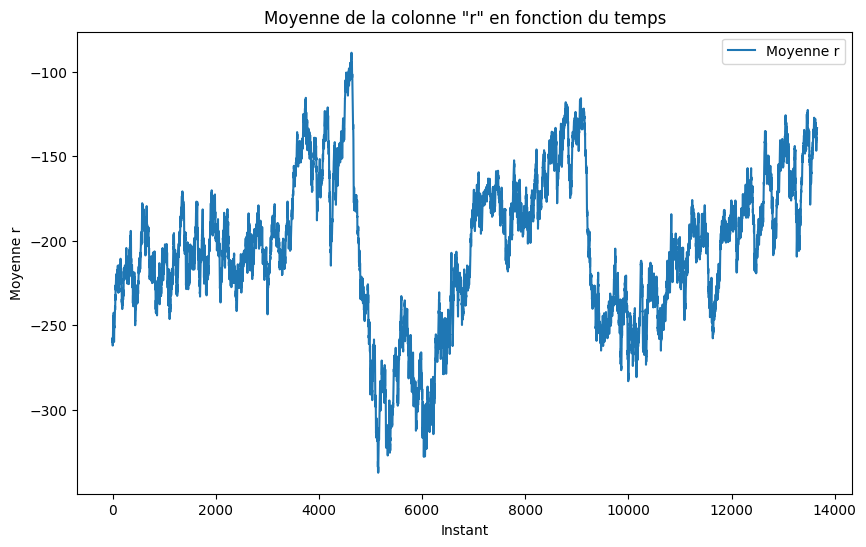

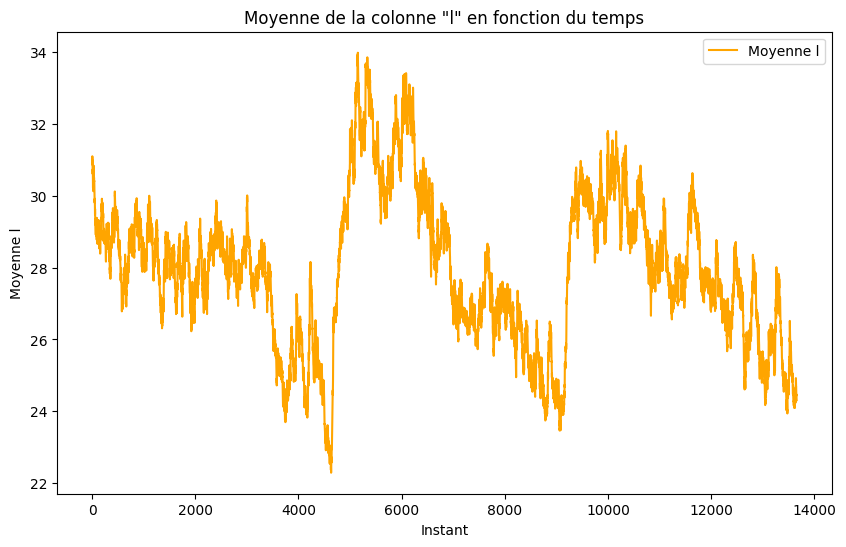

In [305]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Chemin vers le dossier contenant les fichiers CSV
dossier = "/home/ryad/rl-multi-domain-for-multi-placement/vnf_placement/notebooks/speslogs/vector"

# Initialisation des dictionnaires pour stocker les valeurs de r et l pour chaque instant
valeurs_r = {}
valeurs_l = {}

# Parcourir tous les fichiers dans le dossier
for fichier in os.listdir(dossier):
    if fichier.endswith(".csv"):
        chemin_fichier = os.path.join(dossier, fichier)
        
        # Charger le fichier CSV en tant que DataFrame
        df = pd.read_csv(chemin_fichier, skiprows=1)
        
        # Parcourir les lignes du DataFrame
        for index, row in df.iterrows():
            t = row['t']  # Instant
            
            # Ajouter la valeur de r à valeurs_r
            if t not in valeurs_r:
                valeurs_r[t] = []
            valeurs_r[t].append(row['r'])
            
            # Ajouter la valeur de l à valeurs_l
            if t not in valeurs_l:
                valeurs_l[t] = []
            valeurs_l[t].append(row['l'])

# Calculer les moyennes de r et l pour chaque instant
moyennes_r = {t: sum(valeurs) / len(valeurs) for t, valeurs in valeurs_r.items()}
moyennes_l = {t: sum(valeurs) / len(valeurs) for t, valeurs in valeurs_l.items()}

# Créer un DataFrame pour les moyennes calculées
moyennes_df = pd.DataFrame({'t': list(moyennes_r.keys()), 'moyenne_r': list(moyennes_r.values()), 'moyenne_l': list(moyennes_l.values())})

# Afficher les moyennes calculées
print(moyennes_df)

serie_moyennes_r = pd.Series(moyennes_r)

# Appliquer un lissage exponentiel avec un facteur de lissage alpha (ajustez selon vos besoins)


# Créer un graphique pour la moyenne de la colonne "r"
plt.figure(figsize=(10, 6))
plt.plot(smooth(moyennes_df['moyenne_r'], .99), label='Moyenne r')
plt.xlabel('Instant')
plt.ylabel('Moyenne r')
plt.title('Moyenne de la colonne "r" en fonction du temps')
plt.legend()
plt.show()

# Créer un graphique pour la moyenne de la colonne "l"
plt.figure(figsize=(10, 6))
plt.plot(smooth(moyennes_df['moyenne_l'], .99), label='Moyenne l', color='orange')
plt.xlabel('Instant')
plt.ylabel('Moyenne l')
plt.title('Moyenne de la colonne "l" en fonction du temps')
plt.legend()
plt.show()


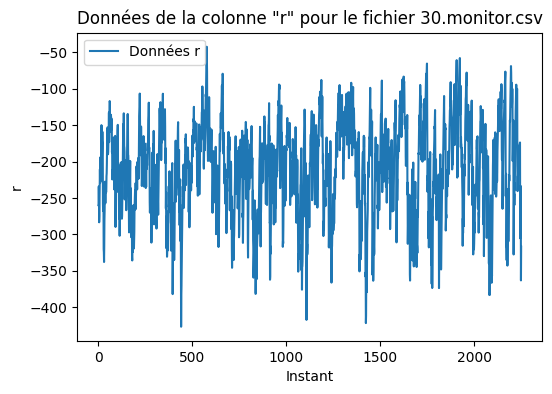

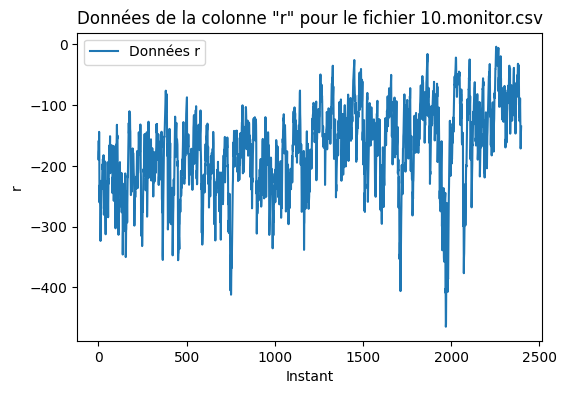

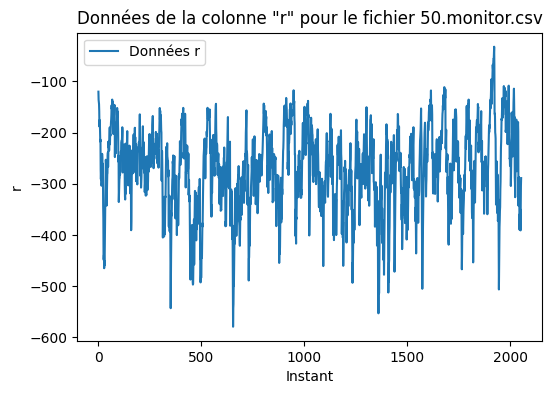

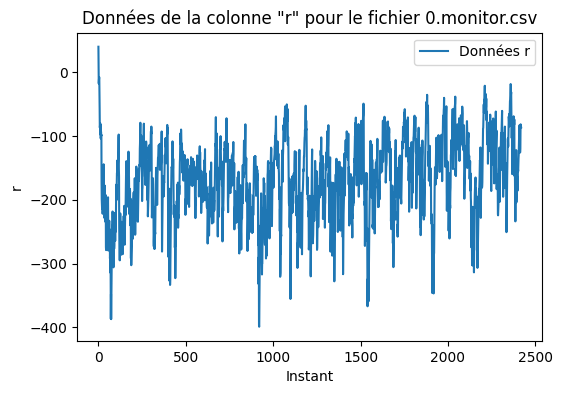

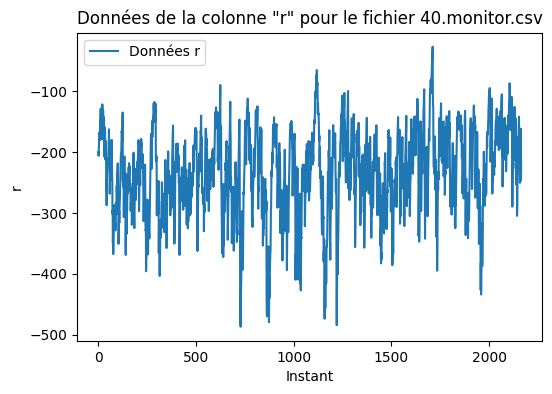

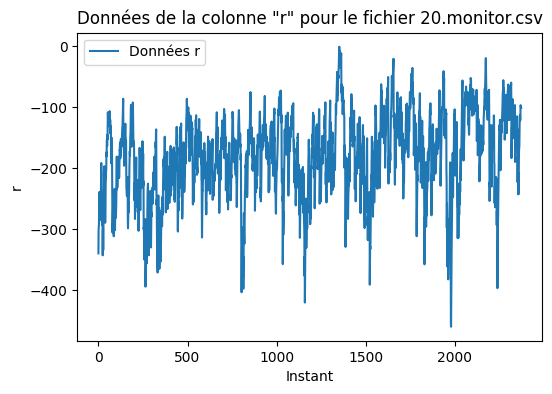

In [304]:
for fichier in os.listdir(dossier):
    if fichier.endswith(".csv"):
        chemin_fichier = os.path.join(dossier, fichier)
        
        # Charger le fichier CSV en tant que DataFrame
        df = pd.read_csv(chemin_fichier, skiprows=1)
        
        # Créer un graphique pour la colonne "r" du fichier actuel
        plt.figure(figsize=(6, 4))
        plt.plot(smooth(df['r'], .90), label='Données r')
        plt.xlabel('Instant')
        plt.ylabel('r')
        plt.title(f'Données de la colonne "r" pour le fichier {fichier}')
        plt.legend()
        plt.show()

In [22]:
def generate_random_resource_configuration(percentage, clusters, min_ram_per_cluster):
    total_ram = sum(cluster['RAM'] for cluster in clusters.values())
    target_ram = total_ram * (percentage / 100)
    
    available_clusters = list(clusters.keys())
    selected_clusters = {cluster: min_ram_per_cluster for cluster in available_clusters}
    remaining_ram = target_ram - (min_ram_per_cluster * len(available_clusters))
    
    print(remaining_ram)
    while remaining_ram > 0 or available_clusters:
        cluster = random.choice(available_clusters)
        available_ram = clusters[cluster]['RAM'] - min_ram_per_cluster
        if available_ram <= remaining_ram:
            selected_clusters[cluster] += available_ram
            remaining_ram -= available_ram
        if not available_clusters:
            available_clusters = list(clusters.keys())
        available_clusters.remove(cluster)

    return selected_clusters

In [34]:
!echo $no_proxy

"localhost,127.0.0.1"


In [37]:
_result_clus = requests.get(f'http://localhost:1234/base_clusters').json()["clusters"]
_result_clus = {int(key): value for key, value in _result_clus.items()}
print(_result_clus)

<Response [200]>
{0: [3, 6, 7], 1: [2, 4, 5], 2: [0, 1], 3: [8, 9, 10]}


In [63]:
params = {
        "ep" : "Request",
        "lp" : 0.9,               #load pourcentage for the load reset  
        "rew_st_s" : 100,     
        "rew_st_f" : -0,     
        "rew_chain_s" : 0,
        "rew_chain_f" : -50,
        "rew_type" : "Best",
        "rew_rs_step_tries" : 5,  
        }

load_pourcent = params["lp"]
_episode_type = params["ep"]
_pm = PlacementModule(_domaines, RL_boundaries, DEFAULT_VNF, DEFAULT_VL, edges_clusters, _init_load = 0,
_clustering = False, _clusters = None)
"""
_pm = PlacementModule(_domaines, RL_boundaries, DEFAULT_VNF, DEFAULT_VL, edges_clusters, _init_load = 0,
_clustering = True, _nb_cluster =4, _clusters = None)

"""
_clpenv = ClusEnv(_id_domain = 0,boundaries= RL_boundaries, requests= None,
                        PModule = _pm, episode_type = _episode_type, reward_type = params["rew_type"], 
                        _reset_load_pourcent = load_pourcent, 
                        mask_cpu = False,
                        mask_ram = False, 
                        mask_bw = False, 
                        mask_delay = True,
                        clustering = False,
                        #nb_cluster = True,
                        #keep_clusters = False,
                        rew_st_s = params["rew_st_s"] , 
                        rew_st_f = params["rew_st_f"],
                        rew_chain_s = params["rew_chain_s"],
                        rew_chain_f = params["rew_chain_f"],
                        rew_rs_step_tries = params["rew_rs_step_tries"],
                     )

In [64]:
ram_loads = []
cpu_loads = []
acp = 0
_ram_load = 0
_cpu_load = 0

i = 0

while (_cpu_load < 0.7) and (_ram_load < 0.7):
    obs = _clpenv.reset()
    obs_send = {}
    obs_send["Infra"] = obs["Infra"].tolist()
    obs_send["Vnf"] = obs["Vnf"].tolist()

    data = {
        "input": obs_send
    }

    done = False
    while not done :
        url = "http://localhost:1234/predict"
        response = requests.post(url, json=data)

        action = int(response.json()["prediction"])

        obs, reward, done, _ = _clpenv.step(action)
        obs_send = {}
        obs_send["Infra"] = obs["Infra"].tolist()
        obs_send["Vnf"] = obs["Vnf"].tolist()
    if reward > 0 :
        acp = acp + 1
    _ram_load = _clpenv._ram_load
    _cpu_load = _clpenv._cpu_load

    ram_loads.append(_ram_load)
    cpu_loads.append(_cpu_load)
    i += 1
    if i % 100 :
        print(f"RAM: {_ram_load}, CPU: {_cpu_load}")
    if i > 1000 :
        break


RAM: 1.835474420552874e-05, CPU: 9.7375632597263e-06
RAM: 1.835474420552874e-05, CPU: 9.7375632597263e-06
RAM: 1.835474420552874e-05, CPU: 9.7375632597263e-06
RAM: 1.835474420552874e-05, CPU: 9.7375632597263e-06
RAM: 1.835474420552874e-05, CPU: 9.7375632597263e-06
RAM: 1.835474420552874e-05, CPU: 9.7375632597263e-06
RAM: 1.835474420552874e-05, CPU: 9.7375632597263e-06
RAM: 1.835474420552874e-05, CPU: 9.7375632597263e-06
RAM: 1.835474420552874e-05, CPU: 9.7375632597263e-06
RAM: 1.835474420552874e-05, CPU: 9.7375632597263e-06
RAM: 1.835474420552874e-05, CPU: 9.7375632597263e-06
RAM: 1.835474420552874e-05, CPU: 9.7375632597263e-06
RAM: 1.835474420552874e-05, CPU: 9.7375632597263e-06
RAM: 1.835474420552874e-05, CPU: 9.7375632597263e-06
RAM: 1.835474420552874e-05, CPU: 9.7375632597263e-06
RAM: 1.835474420552874e-05, CPU: 9.7375632597263e-06
RAM: 1.835474420552874e-05, CPU: 9.7375632597263e-06
RAM: 1.835474420552874e-05, CPU: 9.7375632597263e-06
RAM: 1.835474420552874e-05, CPU: 9.73756325972

RAM: 0.03751061552334156, CPU: 0.021851172204719993
RAM: 0.03751061552334156, CPU: 0.021851172204719993
RAM: 0.03751061552334156, CPU: 0.021851172204719993
RAM: 0.0750028763024776, CPU: 0.04369260684618004
RAM: 0.0750028763024776, CPU: 0.04369260684618004
RAM: 0.0750028763024776, CPU: 0.04369260684618004
RAM: 0.0750028763024776, CPU: 0.04369260684618004
RAM: 0.0750028763024776, CPU: 0.04369260684618004
RAM: 0.0750028763024776, CPU: 0.04369260684618004
RAM: 0.0750028763024776, CPU: 0.04369260684618004
RAM: 0.0750028763024776, CPU: 0.04369260684618004
RAM: 0.0750028763024776, CPU: 0.04369260684618004
RAM: 0.0750028763024776, CPU: 0.04369260684618004
RAM: 0.0750028763024776, CPU: 0.04369260684618004
RAM: 0.0750028763024776, CPU: 0.04369260684618004
RAM: 0.0750028763024776, CPU: 0.04369260684618004
RAM: 0.0750028763024776, CPU: 0.04369260684618004
RAM: 0.0750028763024776, CPU: 0.04369260684618004
RAM: 0.0750028763024776, CPU: 0.04369260684618004
RAM: 0.0750028763024776, CPU: 0.043692606846

In [66]:
import json

result = {
    "type" : "Classique RL",
    "ram_loads" : ram_loads,
    "cpu_loads" : cpu_loads,
    "acp" : acp,
}

file_path = "no_clus.json"

# Open the file in write mode and use json.dump() to serialize the dictionary to the file
with open(file_path, "w") as json_file:
    json.dump(result, json_file)

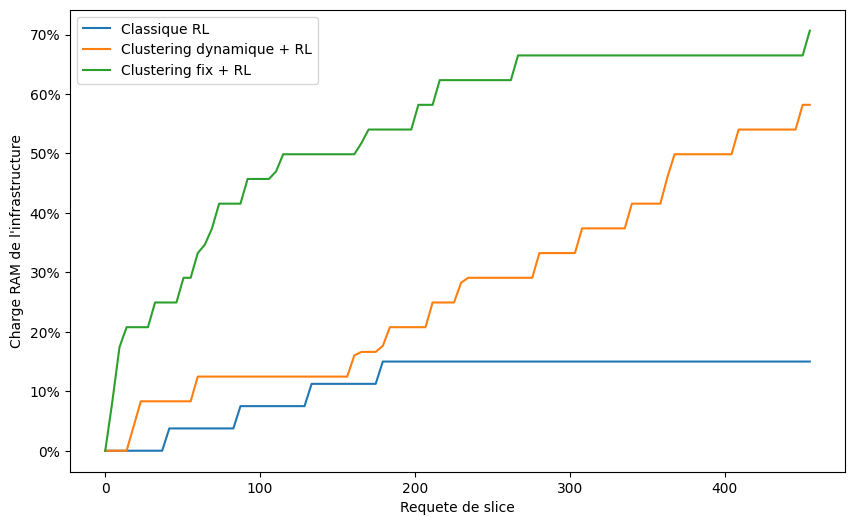

In [75]:
import matplotlib.pyplot as plt
import json
import numpy as np
from matplotlib.ticker import FuncFormatter


# Liste des noms de fichiers JSON
fichiers_json = ["no_clus.json", "var_clus.json", "fix_clus.json"]
labels = ["Classique RL", "Clustering dynamique + RL", "Clustering fix + RL"]
# Liste pour stocker les données des trois modèles
donnees_modèles = []

min_len = float('inf')
# Lire les données depuis les fichiers JSON
for fichier in fichiers_json:
    with open(fichier, 'r') as json_file:
        donnees_modele = json.load(json_file)["ram_loads"]
        donnees_modèles.append(donnees_modele)
        min_len = min(min_len, len(donnees_modele))
# Créer une liste d'indices plus denses pour un graphique continu
indices_x_continu = np.linspace(0, min_len - 1, 100)

# Tracer les trois modèles sur le même graphique avec interpolation
plt.figure(figsize=(10, 6))  # Ajustez la taille de la figure si nécessaire


for i, donnees_modele in enumerate(donnees_modèles):
    valeurs_interpolées = np.interp(indices_x_continu, range(min_len), donnees_modele[:min_len])
    plt.plot(indices_x_continu, valeurs_interpolées, label=labels[i])
    
# Ajouter des étiquettes aux axes et une légende
plt.xlabel('Requete de slice')
plt.ylabel("Charge RAM de l'infrastructure")
plt.legend()
def pourcentage_formatter(x, pos):
    return f'{x:.0%}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(pourcentage_formatter))

# Afficher le graphique
plt.show()

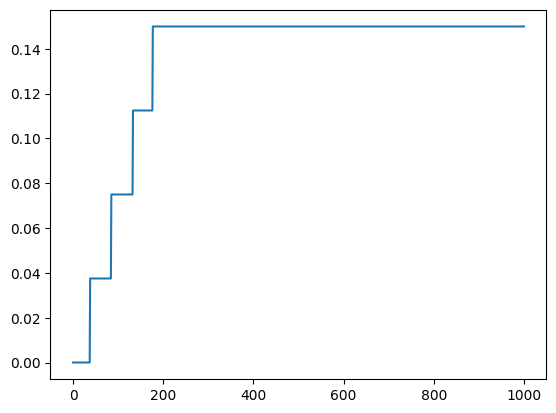

In [79]:
plt.plot(donnees_modèles[0])

In [78]:
donnees_modèles[0]

[1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 1.835474420552874e-05,
 0.03751061552334156,
 0.03751061552334156,
 0.03751061552334156,
 0.03751061552334156,


In [30]:
log_dir = "./speslogs/clus"

model_clus = PPO(
                "MultiInputPolicy", 
                _clpenv, 
                verbose=1, 
                tensorboard_log = log_dir, 
                device= "cuda", 
                #**ppo_parm,
)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [36]:
model_clus.learn(400000)

Logging to ./speslogs/clus/PPO_20
CPU: 0.07046132195931176 RAM: 0.12468226280863315 BW: 0.0
ACP:3, REF:0, AR:1.0
CPU: 0.07046155964628276 RAM: 0.12468277721991883 BW: 0.0
ACP:3, REF:0, AR:1.0
CPU: 0.07046032537397551 RAM: 0.12468045093255509 BW: 0.0
ACP:3, REF:0, AR:1.0
CPU: 0.07046076456209238 RAM: 0.12468122655711855 BW: 0.0
ACP:3, REF:0, AR:1.0
CPU: 0.07045956729581404 RAM: 0.12467902330639014 BW: 0.0
ACP:3, REF:0, AR:1.0
CPU: 0.0704613839838727 RAM: 0.12468245508736375 BW: 0.0
ACP:3, REF:0, AR:1.0
CPU: 0.07045964407109417 RAM: 0.12467918742454509 BW: 0.0
ACP:3, REF:0, AR:1.0
CPU: 0.07046148617177361 RAM: 0.12468259686364291 BW: 0.0
ACP:3, REF:0, AR:1.0
CPU: 0.070461134768392 RAM: 0.1246819591001046 BW: 0.0
ACP:3, REF:0, AR:1.0
CPU: 0.07046143007515882 RAM: 0.12468252430100213 BW: 0.0
ACP:3, REF:0, AR:1.0
CPU: 0.07046121177104447 RAM: 0.12468209631384297 BW: 0.0
ACP:3, REF:0, AR:1.0
CPU: 0.07046080716913306 RAM: 0.12468129159736385 BW: 0.0
ACP:3, REF:0, AR:1.0
CPU: 0.070461559889966

KeyboardInterrupt: 

In [1]:
dispo = {'cluster-c1': {'RAM': 4372.95703125, 'CPU': 2.7409564815426513}, 
         'cluster-c10': {'RAM': 4489.69140625, 'CPU': 2.7610473437294}, 
        'cluster-c2': {'RAM': 4493.51171875, 'CPU': 2.7736120196913383},
        'cluster-c3': {'RAM': 4495.4609375, 'CPU': 2.7832016581886196},
        'cluster-c4': {'RAM': 4461.375, 'CPU': 2.757656933342214}, 
        'cluster-c5': {'RAM': 4501.0390625, 'CPU': 2.767851993789014}, 
        'cluster-c6': {'RAM': 4494.31640625, 'CPU': 2.7732968842827685},
        'cluster-c7': {'RAM': 4498.8125, 'CPU': 2.7635888338288512},
        'cluster-c8': {'RAM': 4468.6484375, 'CPU': 2.7840575406645467},
        'cluster-c9': {'RAM': 4448.27734375, 'CPU': 2.764806127839378}, 
         'cluster-c11': {'RAM': 4512.73828125, 'CPU': 2.7766413269517054}}

In [23]:
MLFLOW_TRACKING_URI = "http://127.0.01:5005"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [26]:
os.environ["no_proxy"] = 'localhost,127.0.0.1'

In [28]:
!echo $no_proxy

localhost,127.0.0.1


In [56]:
path = '/home/ryad/rl-multi-domain-for-multi-placement/vnf_placement/PlacementModule/volume_mlflow/mlflow/mlartifacts/602262455942456504/f3f4939a58e54583926f399af13ea7f3/artifacts/test7'
model_prod = mlflow.pyfunc.load_model(path)
ppo_mod = model_prod.unwrap_python_model().ppo_model

hna


/home/ryad/rl-multi-domain-for-multi-placement/venv/lib/python3.10/site-packages/stable_baselines3/common/policies.py:458: UserWarning: As shared layers in the mlp_extractor are deprecated and will be removed in SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


In [62]:
ppo_mod = model_prod.unwrap_python_model().ppo_model

In [63]:
ppo_mod

In [69]:
tuner.evaluate_policy(
 ppo_mod,
 _clpenv,
 n_eval_episodes = 10,
 deterministic = False,
 return_episode_success_len = True,
 return_episode_rewards = True
)

CPU: 0.07210352725735059 RAM: 0.1287443468341536 BW: 0.0
ACP:3, REF:0, AR:1.0
CPU: 0.07046167043618656 RAM: 0.12468301232481704 BW: 0.0
ACP:3, REF:0, AR:1.0
CPU: 0.07046155635072449 RAM: 0.12468278087343032 BW: 0.0
ACP:3, REF:0, AR:1.0


([1200.0,
  1200.0,
  1200.0,
  1200.0,
  1200.0,
  1200.0,
  1200.0,
  1200.0,
  1200.0,
  1200.0],
 [12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
 [12, 12, 12, 12, 12, 12, 12, 12, 12, 12])

In [70]:
obs = {'Infra': [[2.768531123072263, 4516.35546875, 20.0], 
[2.739015225415187, 4401.10546875, 20.0],
 [2.7756589603012087, 4483.69140625, 20.0], 
 [2.763810182586669, 4498.33984375, 3.0],
  [2.775216255490573, 4468.73828125, 0.0]], 
  'Vnf': [0.06, 300, 4.55]}

In [161]:
ppo_mod.get_parameters()

{'policy': OrderedDict([('mlp_extractor.policy_net.0.weight',
               tensor([[ 0.0705,  0.1778, -0.0193,  ..., -0.0059,  0.1066, -0.0004],
                       [-0.0109,  0.0931, -0.1523,  ...,  0.0264,  0.1510, -0.0155],
                       [-0.2013, -0.1507,  0.2139,  ..., -0.2332, -0.0023, -0.0068],
                       ...,
                       [-0.0433,  0.1145, -0.0081,  ..., -0.1042, -0.1892, -0.1782],
                       [ 0.1192,  0.2285, -0.1896,  ...,  0.0641, -0.1674,  0.0956],
                       [-0.1314, -0.0694, -0.1319,  ..., -0.0141, -0.1386,  0.0652]],
                      device='cuda:0')),
              ('mlp_extractor.policy_net.0.bias',
               tensor([-0.2074,  0.0955,  0.2228,  0.1163,  0.0459,  0.0736,  0.0040,  0.1432,
                        0.0930, -0.1656, -0.0953, -0.2288,  0.0909,  0.1124,  0.1900,  0.0172,
                       -0.0453,  0.1008, -0.0824,  0.0639, -0.0628,  0.1333, -0.1212,  0.1718,
                       